In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import InceptionV3
from keras.models import Model
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score



# Load the Dogs vs. Cats dataset
train_dataset, info = tfds.load('cats_vs_dogs', split='train[:80%]', with_info=True, as_supervised=True)
test_dataset = tfds.load('cats_vs_dogs', split='train[80%:]', with_info=False, as_supervised=True)


# Preprocess the data
def preprocess_image(image, label):
    #Normalize the pixel values
    image = tf.cast(image, tf.float32) / 255.0
    # Resize the image to (150,150)
    image = tf.image.resize(image, (299, 299))
    return image, label

train_data = train_dataset.map(preprocess_image).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_data = test_dataset.map(preprocess_image).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteEX21MR/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


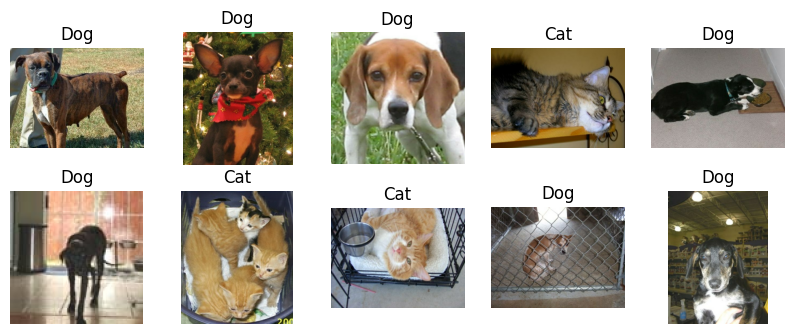

In [3]:
##show some of images with their labels
def show_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title('Dog' if label.numpy() else 'Cat')
        plt.axis('off')
    plt.show()

show_images(train_dataset, 10)

In [4]:
# Load the Inception-v3 model
inception_model =InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299, 3))
print(inception_model.summary())

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [5]:
#dont forget to freeze the pretrained part
inception_model.trainable = False

#create your mode
model = models.Sequential([
    inception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None


In [7]:
#train your model
history = model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
582/582 [==============================] - 116s 174ms/step - loss: 0.0665 - accuracy: 0.9815 - val_loss: 0.0231 - val_accuracy: 0.9942
Epoch 2/5
582/582 [==============================] - 97s 163ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0192 - val_accuracy: 0.9936
Epoch 3/5
582/582 [==============================] - 100s 169ms/step - loss: 0.0183 - accuracy: 0.9943 - val_loss: 0.0177 - val_accuracy: 0.9946
Epoch 4/5
582/582 [==============================] - 97s 163ms/step - loss: 0.0159 - accuracy: 0.9952 - val_loss: 0.0167 - val_accuracy: 0.9953
Epoch 5/5
582/582 [==============================] - 101s 169ms/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0163 - val_accuracy: 0.9946


146/146 [==============================] - 18s 119ms/step - loss: 0.0163 - accuracy: 0.9946
Test accuracy: 0.994625985622406


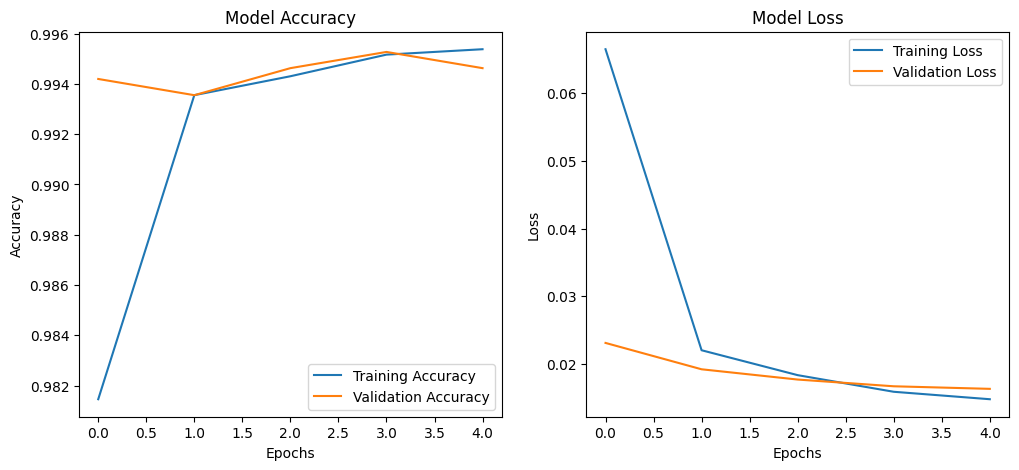

In [8]:
#report the accuracy on your test set
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy}')

# Plot the accuracy and loss curves
plt.figure(figsize=(12, 5))

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()